In [116]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from datetime import datetime

%matplotlib inline

In [117]:
raw_data = pd.read_csv('2007.csv')
list(raw_data.columns)


['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [118]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

DepTime               160748
ArrTime               177927
TailNum                   22
ActualElapsedTime     177927
CRSElapsedTime           994
AirTime               177927
ArrDelay              177927
DepDelay              160748
CancellationCode     7292466
dtype: int64

In [119]:
#Get rid of flights that were cancelled since they couldn't be late.

df2007 = raw_data[raw_data.CancellationCode.isnull()]

#Get rid of Cancellation code since it comes up only when an aircraft is cancelled. We also won't need Year since it's 2007.
df2007 = df2007.drop(['Year', 'FlightNum', 'TailNum', 'Dest', 'Cancelled', 'Diverted', 'DayofMonth','CancellationCode'], 1)
# Count nulls 
null_count = df2007.isnull().sum()
null_count[null_count>0]

ArrTime              17179
ActualElapsedTime    17179
CRSElapsedTime         727
AirTime              17179
ArrDelay             17179
dtype: int64

In [120]:
#Dropping out cancelled flights got rid of the majority of our nulls. The rest seem to be issues with Arrival time/delay, so let's get rid of them all. 
df2007 = df2007.dropna()
null_count = df2007.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [121]:
#Turn this into a classification with the definition that a late plane is one that arrives 30 minutes or more late.
threshold = 30.0
df2007['Late'] = np.where(df2007['ArrDelay'] >= threshold, 1,0)

In [122]:
print(df2007['Late'].value_counts())

0    6177946
1    1097341
Name: Late, dtype: int64


In [123]:
#Rebalance the data
not_late = df2007.loc[np.where(df2007['Late'] == 0)]

# Take a random sample from the not lates
msk = np.random.rand(len(not_late)) < 0.15
not_data = not_late[msk]

df2 = not_data.append(df2007.loc[np.where(df2007['Late'] == 1)])

print(df2['Late'].value_counts())

0.0    1671723
1.0     300791
Name: Late, dtype: int64


In [124]:
null_count = df2.isnull().sum()
null_count[null_count>0]

Month                49764
DayOfWeek            49764
DepTime              49764
CRSDepTime           49764
ArrTime              49764
CRSArrTime           49764
UniqueCarrier        49764
ActualElapsedTime    49764
CRSElapsedTime       49764
AirTime              49764
ArrDelay             49764
DepDelay             49764
Origin               49764
Distance             49764
TaxiIn               49764
TaxiOut              49764
CarrierDelay         49764
WeatherDelay         49764
NASDelay             49764
SecurityDelay        49764
LateAircraftDelay    49764
Late                 49764
dtype: int64

It took the following time to complete this task: 7:15:32.705669


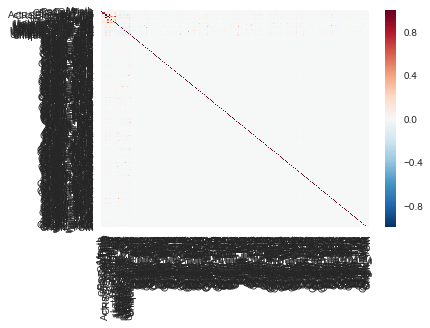

In [125]:
start = datetime.now()
#Turn the string features into dummies
df2007 = pd.get_dummies(df2007)
print('It took the following time to complete this task:', datetime.now() - start)

In [126]:
m = df2007.isnull().any()
print("========= COLUMNS WITH NULL VALUES =================")
print(m[m])
print("========= COLUMNS WITH INFINITE VALUES =================")
m = np.isfinite(df2007.select_dtypes(include=['float64'])).any()
print(m[m])

========= COLUMNS WITH NULL VALUES =================
Series([], dtype: bool)
========= COLUMNS WITH INFINITE VALUES =================
DepTime              True
ArrTime              True
ActualElapsedTime    True
CRSElapsedTime       True
AirTime              True
ArrDelay             True
DepDelay             True
dtype: bool


In [127]:
start = datetime.now()
#Use Lasso/RFE to get the best features
lr = LogisticRegression(C=1, penalty='l1')

#Set up our X,y
X = df2007.drop(['ArrDelay', 'Late'], 1)
y = df2007['Late']

#Set up our Recursive Feature Elimination
rfe = RFE(lr,n_features_to_select=8) 
fit = rfe.fit(X,y)
result_RFE = pd.DataFrame(list(zip(X.head(0), rfe.ranking_, rfe.support_)),
                          columns=['Features','Ranking','Support'] ) 
print(result_RFE.sort_values('Ranking'))
print('It took the following time to complete this task:', datetime.now() - start)

              Features  Ranking  Support
204         Origin_LIH        1     True
337         Origin_WYS        1     True
245         Origin_OGG        1     True
261         Origin_PIH        1     True
186         Origin_IYK        1     True
192         Origin_KOA        1     True
128         Origin_EKO        1     True
185         Origin_ITO        1     True
168         Origin_HNL        2    False
42          Origin_ACK        3    False
253         Origin_OXR        4    False
305         Origin_SLE        5    False
330         Origin_TWF        6    False
72          Origin_BLI        7    False
316         Origin_SUN        8    False
210         Origin_LWS        9    False
264         Origin_PLN       10    False
77          Origin_BPT       11    False
298         Origin_SGU       12    False
98          Origin_CLD       13    False
267         Origin_PSC       14    False
82          Origin_BTM       15    False
92          Origin_CEC       16    False
105         Orig

In [128]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=9e9)
X = df2007[['AirTime', 'DepDelay', 'TaxiIn', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 
            'LateAircraftDelay']]
lr.fit(X, y)


# Inspect the results.
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)
print('\nR-squared:')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))
print('It took the following time to complete this task:', datetime.now() - start)


Coefficients: 
 [[ -7.38870391e-04   8.27110708e-04  -4.34713142e-03   1.46636775e+00
    1.46711999e+00   1.46855497e+00   1.45947453e+00   1.46723772e+00]]

Intercept: 
 [-43.19910594]

R-squared:
1.0
[ 1.  1.  1.  1.  1.]
It took the following time to complete this task: 0:04:40.810311


In [129]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=1, penalty='l1')
lr.fit(X, y)


# Inspect the results.
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)
print('\nR-squared:')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))
print('It took the following time to complete this task:', datetime.now() - start)


Coefficients: 
 [[-0.00272921  0.02717491 -0.01051492  0.24924233  0.25221297  0.2810542
   0.24100024  0.24929963]]

Intercept: 
 [-8.00455812]

R-squared:
0.99648275044
[ 0.9955988   0.99571357  0.99611287  0.99609569  0.99815677]
It took the following time to complete this task: 0:49:18.874713


In [130]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=1, penalty='l')
lr.fit(X, y)


# Inspect the results.
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)
print('\nR-squared:')
print(lr.score(X, y))
print(cross_val_score(lr, X, y, cv=5))
print('It took the following time to complete this task:', datetime.now() - start)

ValueError: Unsupported set of arguments: The combination of penalty='l' and loss='logistic_regression' is not supported, Parameters: penalty='l', loss='logistic_regression', dual=False